**Student Name:** Mahebobe Fayyaz Savanur

**Student ID:** 47969725

# Assignment 3 Part 2 - Find complex answers to medical questions

*Submission deadline: Friday 24 May 2024, 11:55pm.*

*Assessment marks: 15 marks (15% of the total unit assessment)*

Unless a Special Consideration request has been submitted and approved, a 5% penalty (of the total possible mark of the task) will be applied for each day a written report or presentation assessment is not submitted, up until the 7th day (including weekends). After the 7th day, a grade of ‘0’ will be awarded even if the assessment is submitted. The submission time for all uploaded assessments is 11:55 pm. A 1-hour grace period will be provided to students who experience a technical concern. For any late submission of time-sensitive tasks, such as scheduled tests/exams, performance assessments/presentations, and/or scheduled practical assessments/labs, please apply for [Special Consideration](https://students.mq.edu.au/study/assessment-exams/special-consideration).

Note that the work submitted should be your own work. You are allowed to use AI-based code generators to help you understand the problem and possible solutions, but you are not allowed to use the code generated by these tools (see below).

You are allowed to base your code on the code presented in the unit lectures and lecture notebooks.

**A note on the use of AI generators**: In this assignment, we view AI code generators such as copilot, CodeGPT, etc as tools that can help you write code quickly. You are allowed to use these tools, but with some conditions. To understand what you can and what you cannot do, please visit these information pages provided by Macquarie University.

Artificial Intelligence Tools and Academic Integrity in FSE - https://bit.ly/3uxgQP4
If you choose to use these tools, make the following explicit in your Jupyter notebook, under a section with heading "Use of AI generators in this assignment" :

* What part of your code is based on the output of such tools,
* What tools you used,
* What prompts you used to generate the code or text, and
* What modifications you made on the generated code or text.
  
This will help us assess your work fairly.



# Overall Task Review

In assignment 3 you will work on a task of "query-focused summarisation" on medical questions where the goal is, given a medical question and a list of sentences extracted from relevant medical publications, to determine which of these sentences from the list can be used as part of the answer to the question. Assignment 3 is divided into two parts. Part 1 will help you get familar with the data, and Part 2 requires you to implement deep neural networks.

We will use data that has been derived from the **BioASQ challenge** (http://www.bioasq.org/), after some data manipulation to make it easier to process for this assignment. The BioASQ challenge organises several "shared tasks", including a task on biomedical semantic question answering which we are using here. The data are in the file `bioasq10_labelled.csv`, which is part of the zip file provided. Each row of the file has a question, a sentence text, and a label that indicates whether the sentence text is part of the answer to the question (1) or not (0).

# Data Review

The following code uses pandas to store the file `bioasq10_labelled.csv` in a data frame and show the first rows of data. For this code to run, first you need to unzip the file `data.zip`:

In [ ]:
!unzip data.zip

In [ ]:
import pandas as pd
from google.colab import files
uploaded = files.upload()
dataset = pd.read_csv("bioasq10b_labelled.csv")
dataset.head()

Saving bioasq10b_labelled.csv to bioasq10b_labelled (1).csv
Saving dev_test.csv to dev_test (1).csv
Saving test.csv to test (1).csv
Saving training.csv to training (1).csv


,qid,sentid,question,sentence text,label
0,0,0,Is Hirschsprung disease a mendelian or a multi...,Hirschsprung disease (HSCR) is a multifactoria...,0
1,0,1,Is Hirschsprung disease a mendelian or a multi...,"In this study, we review the identification of...",1
2,0,2,Is Hirschsprung disease a mendelian or a multi...,The majority of the identified genes are relat...,1
3,0,3,Is Hirschsprung disease a mendelian or a multi...,The non-Mendelian inheritance of sporadic non-...,1
4,0,4,Is Hirschsprung disease a mendelian or a multi...,Coding sequence mutations in e.g.,0


The columns of the CSV file are:

* `qid`: an ID for a question. Several rows may have the same question ID, as we can see above.
* `sentid`: an ID for a sentence.
* `question`: The text of the question. In the above example, the first rows all have the same question: "Is Hirschsprung disease a mendelian or a multifactorial disorder?"
* `sentence text`: The text of the sentence.
* `label`: 1 if the sentence is a part of the answer, 0 if the sentence is not part of the answer.

# Now Let's get started for the Part 2 tasks

Use the provided files `training.csv`, `dev_test.csv`, and `test.csv` in the data.zip file for all the tasks below.

# Task 1 (5 marks): Simple Siamese NN

Implement a simple TensorFlow-Keras neural model that has the following sequence of layers:

1. An input layer that will accept the tf.idf of triplet data. The input of Siamese network is a triplet, consisting of anchor (i.e., the question), positive answer, negative answer.
2. 3 hidden layers and a relu activation function. You need to determine the size of the hidden layers.
3. Implement a class that serves as a distance layer. It returns the squared Euclidean distance between anchor and positive answer, as well as that between anchor and negative answer
4. Implement a function that prepares raw data in csv files into triplets. Note that it is important to keep the similar number of positive pairs and negative pairs. For example, if a question has 10 anwsers, then we at most can have 10 positive pairs and it is good to associate this question with 10~20 negative sentences.


Train the model with the training data and use the `dev_test` set to determine a good size of the hidden layer.

With the model that you have trained, implement a summariser that returns the $n$ sentences with highest predicted score. Use the following function signature:

```{python}
def nn_summariser(csvfile, questionids, n=1):
   """Return the IDs of the n sentences that have the highest predicted score.
      The input questionids is a list of question ids.
      The output is a list of lists of sentence ids
   """

```

Report the final results using the test set. Remember: use the test set to report the final results of the best system only.

The breakdown of marks is as follows:

* **1 mark** if the NN model has the correct layers, the correct activation functions, and the correct loss function.
* **1 mark** if the code passes input to the model correctly.
* **1 mark** if the code returns the IDs of the $n$ sentences that have the highest prediction score in the given question.
* **1 mark** if the notebook reports the F1 scores of the test sets and comments on the results.
* **1 mark** for good coding and documentation in this task. In particular, the code and results must include evidence that shows your choice of best size of the hidden layer. The explanations must be clear and concise. To make this task less time-consuming, use $n=1$.

In [1]:
#Step 1: Import Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Dense,LSTM, Layer,Embedding
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import BertTokenizer, TFBertModel
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
#Step 2: Load and Prepare Data
# Load data
train_data = pd.read_csv('training.csv').head(500)
dev_test_data = pd.read_csv('dev_test.csv').head(300)
test_data = pd.read_csv('test.csv').head(300)

# Function to prepare triplets
def prepare_triplets(data):
    triplets = []
    for qid, group in data.groupby('qid'):
        question = group['question'].values[0]
        positive_answers = group[group['label'] == 1][['sentid', 'sentence text']].values.tolist()
        negative_answers = group[group['label'] == 0][['sentid', 'sentence text']].values.tolist()
        for pos in positive_answers:
            for neg in negative_answers:
                triplets.append((qid, question, pos[0], pos[1], neg[0], neg[1]))
    return triplets

# Prepare triplets for each dataset
train_triplets = prepare_triplets(train_data)
dev_test_triplets = prepare_triplets(dev_test_data)
test_triplets = prepare_triplets(test_data)


In [71]:
def vectorize_triplets(triplets, vectorizer):
    qids = []
    pos_ids = []
    neg_ids = []
    anchors = []
    positives = []
    negatives = []
    for qid, anchor, pos_id, positive, neg_id, negative in triplets:
        qids.append(qid)
        pos_ids.append(pos_id)
        neg_ids.append(neg_id)
        anchors.append(vectorizer.transform([anchor]).toarray().flatten())
        positives.append(vectorizer.transform([positive]).toarray().flatten())
        negatives.append(vectorizer.transform([negative]).toarray().flatten())
    return np.array(qids), np.array(pos_ids), np.array(neg_ids), np.array(anchors), np.array(positives), np.array(negatives)

# Combine all texts to fit the vectorizer
all_sentences = pd.concat([train_data['sentence text'], dev_test_data['sentence text'], test_data['sentence text']])
vectorizer = TfidfVectorizer()
vectorizer.fit(all_sentences)

# Vectorize each dataset
train_qids, train_pos_ids, train_neg_ids, train_anchors, train_positives, train_negatives = vectorize_triplets(train_triplets, vectorizer)
dev_test_qids, dev_test_pos_ids, dev_test_neg_ids, dev_test_anchors, dev_test_positives, dev_test_negatives = vectorize_triplets(dev_test_triplets, vectorizer)
test_qids, test_pos_ids, test_neg_ids, test_anchors, test_positives, test_negatives = vectorize_triplets(test_triplets, vectorizer)

# Ensure the input dimensions are consistent
input_dim = train_anchors.shape[1]


In [ ]:
#Step 4: Build the Siamese Network
def create_siamese_network(input_dim, layer_sizes):
    input = Input(shape=(input_dim,))
    x = input
    for size in layer_sizes:
        x = Dense(size, activation='relu')(x)
    return Model(input, x)

class DistanceLayer(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):
        anchor, positive, negative = inputs
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), axis=1, keepdims=True)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), axis=1, keepdims=True)
        return tf.concat([ap_distance, an_distance], axis=1)

def triplet_loss(y_true, y_pred):
    margin = 1.0
    ap_distance = y_pred[:, 0]  # Distance between anchor and positive
    an_distance = y_pred[:, 1]  # Distance between anchor and negative
    return tf.reduce_mean(tf.maximum(ap_distance - an_distance + margin, 0))


In [ ]:
hidden_layer_configs = [
    [128, 64, 32],
    [256, 128, 64],
    [64, 32, 16],
    [128, 128, 128],
]

best_config = None
best_loss = float('inf')

def evaluate_model(model, questions, positive_answers, negative_answers):
    dummy_labels = np.zeros((questions.shape[0], 1))
    return model.evaluate([questions, positive_answers, negative_answers], dummy_labels, verbose=0)

for config in hidden_layer_configs:
    print(f"Evaluating model with hidden layer sizes: {config}")

    # Create the base network
    shared_network = create_siamese_network(input_dim, config)

    # Define inputs
    anchor_input = Input(shape=(input_dim,), name='anchor')
    positive_input = Input(shape=(input_dim,), name='positive')
    negative_input = Input(shape=(input_dim,), name='negative')

    # Process each input through the shared network
    anchor_output = shared_network(anchor_input)
    positive_output = shared_network(positive_input)
    negative_output = shared_network(negative_input)

    # Compute the distances
    distances = DistanceLayer()([anchor_output, positive_output, negative_output])

    # Define the model
    siamese_model = Model(inputs=[anchor_input, positive_input, negative_input], outputs=distances)

    # Compile the model
    siamese_model.compile(optimizer='adam', loss=triplet_loss)

    # Define dummy labels for loss calculation
    dummy_labels = np.zeros((train_anchor.shape[0], 1))

    # Train the model
    siamese_model.fit([train_anchor, train_positive, train_negative],
                      dummy_labels,
                      epochs=5,
                      batch_size=32,
                      validation_data=([dev_test_anchor, dev_test_positive, dev_test_negative], np.zeros((dev_test_anchor.shape[0], 1))),
                      verbose=1)

    # Evaluate the model
    loss = evaluate_model(siamese_model, dev_test_anchor, dev_test_positive, dev_test_negative)
    print(f"Validation loss: {loss}")

    if loss < best_loss:
        best_loss = loss
        best_config = config

print(f"Best hidden layer configuration: {best_config} with loss: {best_loss}")


Evaluating model with hidden layer sizes: [128, 64, 32]
Epoch 1/5
56/56 [==============================] - 2s 23ms/step - loss: 0.4820 - val_loss: 0.9498
Epoch 2/5
56/56 [==============================] - 1s 20ms/step - loss: 0.0060 - val_loss: 0.9696
Epoch 3/5
56/56 [==============================] - 1s 16ms/step - loss: 0.0029 - val_loss: 0.9835
Epoch 4/5
56/56 [==============================] - 1s 24ms/step - loss: 0.0020 - val_loss: 0.9855
Epoch 5/5
56/56 [==============================] - 1s 27ms/step - loss: 0.0018 - val_loss: 0.9869
Validation loss: 0.9869396090507507
Evaluating model with hidden layer sizes: [256, 128, 64]
Epoch 1/5
56/56 [==============================] - 3s 33ms/step - loss: 0.3553 - val_loss: 1.1737
Epoch 2/5
56/56 [==============================] - 2s 29ms/step - loss: 0.0048 - val_loss: 1.1994
Epoch 3/5
56/56 [==============================] - 2s 29ms/step - loss: 0.0035 - val_loss: 1.3806
Epoch 4/5
56/56 [==============================] - 3s 49ms/step - l

In [ ]:
print(f"Training the final model with best hidden layer configuration: {best_config}")

# Create the base network with the best configuration
shared_network = create_siamese_network(input_dim, best_config)

# Define inputs
anchor_input = Input(shape=(input_dim,), name='anchor')
positive_input = Input(shape=(input_dim,), name='positive')
negative_input = Input(shape=(input_dim,), name='negative')

# Process each input through the shared network
anchor_output = shared_network(anchor_input)
positive_output = shared_network(positive_input)
negative_output = shared_network(negative_input)

# Compute the distances
distances = DistanceLayer()([anchor_output, positive_output, negative_output])

# Define the final model
final_siamese_model = Model(inputs=[anchor_input, positive_input, negative_input], outputs=distances)

# Display the model summary
final_siamese_model.summary()

# Compile the final model
final_siamese_model.compile(optimizer='adam', loss=triplet_loss)

# Prepare the data
dummy_labels = np.zeros((train_anchors.shape[0], 1))

# Train the final model
final_siamese_model.fit([train_anchors, train_positives, train_negatives],
                        dummy_labels,
                        epochs=5,
                        batch_size=32,
                        validation_data=([dev_test_anchors, dev_test_positives, dev_test_negatives], np.zeros((dev_test_anchors.shape[0], 1))),
                        verbose=1)


Training the final model with best hidden layer configuration: [128, 64, 32]
Model: "model_53"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 anchor (InputLayer)         [(None, 4071)]               0         []                            
                                                                                                  
 positive (InputLayer)       [(None, 4071)]               0         []                            
                                                                                                  
 negative (InputLayer)       [(None, 4071)]               0         []                            
                                                                                                  
 model_52 (Functional)       (None, 32)                   531552    ['anchor[0][0]',              
              

In [ ]:
def nn_summariser(csvfile, questionids, n=1):
    """Return the IDs of the n sentences that have the highest predicted score.
       The input questionids is a list of question ids.
       The output is a list of lists of sentence ids
    """
    data = pd.read_csv(csvfile, nrows=300)
    triplets = prepare_triplets(data)
    qids, pos_ids, neg_ids, anchors, positives, negatives = vectorize_triplets(triplets, vectorizer)

    summaries = []
    for question_id in questionids:
        question_triplets = [(triplet[0], triplet[2], triplet[4]) for triplet in triplets if triplet[0] == question_id]

        if not question_triplets:
            print(f"No triplets found for question ID {question_id}")
            continue

        question_anchors = np.array([anchors[i] for i, triplet in enumerate(triplets) if triplet[0] == question_id])
        question_positives = np.array([positives[i] for i, triplet in enumerate(triplets) if triplet[0] == question_id])
        question_negatives = np.array([negatives[i] for i, triplet in enumerate(triplets) if triplet[0] == question_id])

        if question_anchors.size == 0 or question_positives.size == 0 or question_negatives.size == 0:
            print(f"Empty data encountered for question ID {question_id}")
            continue

        scores = final_siamese_model.predict([question_anchors, question_positives, question_negatives])
        ranked_indices = np.argsort(scores[:, 0])[:n]  # Since distances are returned in a tuple
        ranked_sentids = [question_triplets[i][1] for i in ranked_indices]  # Get the pos_id for top-ranked sentences
        summaries.append(ranked_sentids)

    return summaries

# Test the summarizer function
questionids = [6, 7, 10]
top_n_sentences = nn_summariser("test.csv", questionids, n=1)
print(top_n_sentences)


4/4 [==============================] - 0s 6ms/step
[[19], [15], [10]]


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

def calculate_f1_score(csvfile, predicted_summaries, questionids):
    data = pd.read_csv(csvfile)
    true_labels = []

    for qid in questionids:
        question_data = data[data['qid'] == qid]
        true_sentids = question_data[question_data['label'] == 1]['sentid'].tolist()
        true_labels.append(true_sentids)

    y_true = []
    y_pred = []

    for true, pred in zip(true_labels, predicted_summaries):
        y_true.extend([1 if sid in true else 0 for sid in range(len(data))])
        y_pred.extend([1 if sid in pred else 0 for sid in range(len(data))])

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    return precision, recall, f1

# Calculate F1 score for test set
test_csv_path = 'test.csv'
test_question_ids = test_data['qid'].unique().tolist()
predicted_summaries = nn_summariser(test_csv_path, test_question_ids, n=1)
precision, recall, f1 = calculate_f1_score(test_csv_path, predicted_summaries, test_question_ids)
print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}")


8/8 [==============================] - 0s 14ms/step
No triplets found for question ID 67
4/4 [==============================] - 0s 8ms/step
Precision: 0.8181818181818182, Recall: 0.16981132075471697, F1 Score: 0.28125


# Task 2 (5 marks): Recurrent NN

Implement a more complex Siamese neural network that is composed of the following layers:

* An embedding layer that generates embedding vectors of the sentence text with 35 dimensions.
* A LSTM layer. You need to determine the size of this LSTM layer, and the text length limit (if needed).
* 3 hidden layers and a relu activation function. You need to determine the size of the hidden layers.

Train the model with the training data, use the `dev_test` set to determine a good size of the LSTM layer and an appropriate length limit (if needed), and report the final results using the test set. Again, remember to use the test set only after you have determined the optimal parameters of the LSTM layer.

Based on your experiments, comment on whether this system is better than the systems developed in the previous tasks.

The breakdown of marks is as follows:

* **1 mark** if the NN model has the correct layers, the correct activation functions, and the correct loss function.
* **1 mark** if the code passes the sentence text to the model correctly. The documentation needs to explain what decisions had to be made to process long sentences. In particular, did you need to truncate the input text, and how did you determine the length limit?
* **1 mark** if the code returns the IDs of the *n* sentences that have the highest prediction score in the given question.
* **1 mark** if the notebook reports the F1 scores of the test sets and comments on the results.
* **1 mark** for good coding and documentation in this task. In particular, the code and results must include evidence that shows your choice of best size of the LSTM layer (and length limit) and hidden layers. The explanations must be clear and concise. To make this task less time-consuming, use $n=1$.

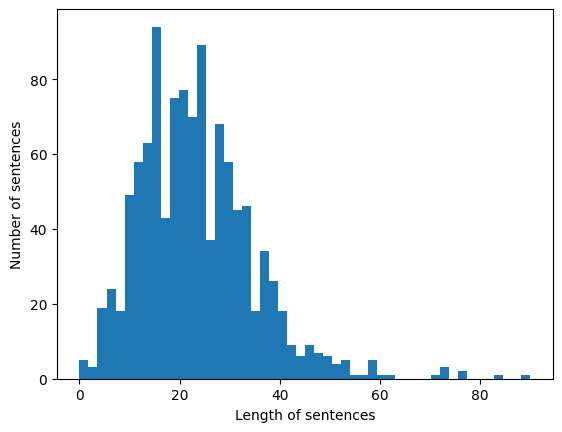

Determined max length for 95% of sentences: 43


In [77]:
# Assuming tokenizer and data preparation from Task 1 are available
import matplotlib.pyplot as plt
import numpy as np
all_sentences = list(train_data['sentence text']) + list(dev_test_data['sentence text']) + list(test_data['sentence text'])
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_sentences)

# Analyze the distribution of sentence lengths
all_sentences_lengths = [len(seq) for seq in tokenizer.texts_to_sequences(all_sentences)]
plt.hist(all_sentences_lengths, bins=50)
plt.xlabel('Length of sentences')
plt.ylabel('Number of sentences')
plt.show()

# Determine the maximum length for 95% of the sentences
max_len = int(np.percentile(all_sentences_lengths, 95))
print(f"Determined max length for 95% of sentences: {max_len}")


In [78]:
def create_siamese_rnn(input_dim, embedding_dim, lstm_size, hidden_layer_sizes, max_len):
    input = Input(shape=(max_len,))
    x = Embedding(input_dim, embedding_dim, input_length=max_len)(input)
    x = LSTM(lstm_size)(x)
    for size in hidden_layer_sizes:
        x = Dense(size, activation='relu')(x)
    return Model(input, x)

class DistanceLayer(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):
        anchor, positive, negative = inputs
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), axis=1, keepdims=True)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), axis=1, keepdims=True)
        return tf.concat([ap_distance, an_distance], axis=1)

def triplet_loss(y_true, y_pred):
    margin = 1.0
    ap_distance = y_pred[:, 0]
    an_distance = y_pred[:, 1]
    return tf.reduce_mean(tf.maximum(ap_distance - an_distance + margin, 0))

hidden_layer_configs = [
    [128, 64, 32],
    [256, 128, 64],
    [64, 32, 16],
    [128, 128, 128],
]
lstm_sizes = [64, 128, 256]

best_config = None
best_loss = float('inf')
best_lstm_size = None


In [81]:
# Tokenize and pad sequences
def tokenize_triplets(triplets, tokenizer, max_len):
    anchors, positives, negatives = [], [], []
    for triplet in triplets:
        anchor_seq = tokenizer.texts_to_sequences([triplet[1]])[0]
        positive_seq = tokenizer.texts_to_sequences([triplet[3]])[0]
        negative_seq = tokenizer.texts_to_sequences([triplet[5]])[0]
        anchors.append(anchor_seq)
        positives.append(positive_seq)
        negatives.append(negative_seq)
    return (pad_sequences(anchors, maxlen=max_len),
            pad_sequences(positives, maxlen=max_len),
            pad_sequences(negatives, maxlen=max_len))

train_anchor, train_positive, train_negative = tokenize_triplets(train_triplets, tokenizer, max_len)
dev_test_anchor, dev_test_positive, dev_test_negative = tokenize_triplets(dev_test_triplets, tokenizer, max_len)
test_anchor, test_positive, test_negative = tokenize_triplets(test_triplets, tokenizer, max_len)


In [84]:
input_dim = len(tokenizer.word_index) + 1
embedding_dim = 35

# Hyperparameter tuning
for lstm_size in lstm_sizes:
    for config in hidden_layer_configs:
        print(f"Evaluating model with LSTM size: {lstm_size} and hidden layer sizes: {config}")

        # Create the base network
        shared_network = create_siamese_rnn(input_dim, embedding_dim, lstm_size, config, max_len)

        # Define inputs
        anchor_input = Input(shape=(max_len,), name='anchor')
        positive_input = Input(shape=(max_len,), name='positive')
        negative_input = Input(shape=(max_len,), name='negative')

        # Process each input through the shared network
        anchor_output = shared_network(anchor_input)
        positive_output = shared_network(positive_input)
        negative_output = shared_network(negative_input)

        # Compute the distances
        distances = DistanceLayer()([anchor_output, positive_output, negative_output])

        # Define the model
        siamese_model = Model(inputs=[anchor_input, positive_input, negative_input], outputs=distances)

        # Compile the model
        siamese_model.compile(optimizer='adam', loss=triplet_loss)

        # Train the model
        dummy_labels = np.zeros((train_anchor.shape[0], 1))
        siamese_model.fit([train_anchor, train_positive, train_negative],
                          dummy_labels,
                          epochs=5,
                          batch_size=32,
                          validation_data=([dev_test_anchor, dev_test_positive, dev_test_negative], np.zeros((dev_test_anchor.shape[0], 1))),
                          verbose=1)

        # Evaluate the model
        loss = siamese_model.evaluate([dev_test_anchor, dev_test_positive, dev_test_negative], np.zeros((dev_test_anchor.shape[0], 1)), verbose=0)
        print(f"Validation loss: {loss}")

        if loss < best_loss:
            best_loss = loss
            best_config = config
            best_lstm_size = lstm_size

print(f"Best LSTM size: {best_lstm_size} with hidden layer configuration: {best_config} and loss: {best_loss}")

Evaluating model with LSTM size: 64 and hidden layer sizes: [128, 64, 32]
Epoch 1/5
56/56 [==============================] - 14s 115ms/step - loss: 0.5724 - val_loss: 1.9355
Epoch 2/5
56/56 [==============================] - 6s 102ms/step - loss: 0.0243 - val_loss: 3.3612
Epoch 3/5
56/56 [==============================] - 5s 91ms/step - loss: 0.0095 - val_loss: 5.3016
Epoch 4/5
56/56 [==============================] - 5s 81ms/step - loss: 0.0122 - val_loss: 3.0603
Epoch 5/5
56/56 [==============================] - 10s 184ms/step - loss: 0.0055 - val_loss: 4.2927
Validation loss: 4.29271936416626
Evaluating model with LSTM size: 64 and hidden layer sizes: [256, 128, 64]
Epoch 1/5
56/56 [==============================] - 26s 105ms/step - loss: 0.5743 - val_loss: 1.7621
Epoch 2/5
56/56 [==============================] - 6s 110ms/step - loss: 0.0325 - val_loss: 3.3398
Epoch 3/5
56/56 [==============================] - 9s 160ms/step - loss: 0.0100 - val_loss: 1.9453
Epoch 4/5
56/56 [=======

In [85]:
print(f"Training the final model with LSTM size: {best_lstm_size} and hidden layer configuration: {best_config}")

# Create the base network with the best configuration
shared_network = create_siamese_rnn(input_dim, embedding_dim, best_lstm_size, best_config, max_len)

# Define inputs
anchor_input = Input(shape=(max_len,), name='anchor')
positive_input = Input(shape=(max_len,), name='positive')
negative_input = Input(shape=(max_len,), name='negative')

# Process each input through the shared network
anchor_output = shared_network(anchor_input)
positive_output = shared_network(positive_input)
negative_output = shared_network(negative_input)

# Compute the distances
distances = DistanceLayer()([anchor_output, positive_output, negative_output])

# Define the final model
final_siamese_model = Model(inputs=[anchor_input, positive_input, negative_input], outputs=distances)

# Display the model summary
final_siamese_model.summary()

# Compile the final model
final_siamese_model.compile(optimizer='adam', loss=triplet_loss)

# Train the final model
dummy_labels = np.zeros((train_anchor.shape[0], 1))
final_siamese_model.fit([train_anchor, train_positive, train_negative],
                        dummy_labels,
                        epochs=5,
                        batch_size=32,
                        validation_data=([dev_test_anchor, dev_test_positive, dev_test_negative], np.zeros((dev_test_anchor.shape[0], 1))),
                        verbose=1)


Training the final model with LSTM size: 128 and hidden layer configuration: [128, 64, 32]
Model: "model_79"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 anchor (InputLayer)         [(None, 43)]                 0         []                            
                                                                                                  
 positive (InputLayer)       [(None, 43)]                 0         []                            
                                                                                                  
 negative (InputLayer)       [(None, 43)]                 0         []                            
                                                                                                  
 model_78 (Functional)       (None, 32)                   255296    ['anchor[0][0]',              


In [87]:
def nn_summariser(csvfile, questionids, n=1):
    """Return the IDs of the n sentences that have the highest predicted score.
       The input questionids is a list of question ids.
       The output is a list of lists of sentence ids
    """
    data = pd.read_csv(csvfile, nrows=300)
    triplets = prepare_triplets(data)
    anchors, positives, negatives = tokenize_triplets(triplets, tokenizer, max_len)

    summaries = []
    for question_id in questionids:
        question_triplets = [(triplet[0], triplet[2], triplet[4]) for triplet in triplets if triplet[0] == question_id]

        if not question_triplets:
            print(f"No triplets found for question ID {question_id}")
            continue

        question_anchors = np.array([anchors[i] for i, triplet in enumerate(triplets) if triplet[0] == question_id])
        question_positives = np.array([positives[i] for i, triplet in enumerate(triplets) if triplet[0] == question_id])
        question_negatives = np.array([negatives[i] for i, triplet in enumerate(triplets) if triplet[0] == question_id])

        if question_anchors.size == 0 or question_positives.size == 0 or question_negatives.size == 0:
            print(f"Empty data encountered for question ID {question_id}")
            continue

        scores = final_siamese_model.predict([question_anchors, question_positives, question_negatives])
        ranked_indices = np.argsort(scores[:, 0])[:n]  # Since distances are returned in a tuple
        ranked_sentids = [question_triplets[i][1] for i in ranked_indices]  # Get the pos_id for top-ranked sentences
        summaries.append(ranked_sentids)

    return summaries


In [89]:
# Define test question IDs
test_question_ids = [6, 7, 10]

# Test the summarizer function
top_n_sentences = nn_summariser('test.csv', test_question_ids, n=1)
print(top_n_sentences)


4/4 [==============================] - 0s 73ms/step
[[19], [0], [22]]


In [90]:
def calculate_f1_score(csvfile, predicted_summaries, questionids):
    data = pd.read_csv(csvfile)
    true_labels = []

    for qid in questionids:
        question_data = data[data['qid'] == qid]
        true_sentids = question_data[question_data['label'] == 1]['sentid'].tolist()
        true_labels.append(true_sentids)

    y_true = []
    y_pred = []

    for true, pred in zip(true_labels, predicted_summaries):
        y_true.extend([1 if sid in true else 0 for sid in range(len(data))])
        y_pred.extend([1 if sid in pred else 0 for sid in range(len(data))])

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    return precision, recall, f1

# Calculate F1 score for test set
test_csv_path = 'test.csv'
test_question_ids = test_data['qid'].unique().tolist()
predicted_summaries = nn_summariser(test_csv_path, test_question_ids, n=1)
precision, recall, f1 = calculate_f1_score(test_csv_path, predicted_summaries, test_question_ids)
print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}")


8/8 [==============================] - 0s 51ms/step
No triplets found for question ID 67
4/4 [==============================] - 0s 45ms/step
Precision: 0.9090909090909091, Recall: 0.18867924528301888, F1 Score: 0.3125


**Comparison and Analysis**:

**1.Precision:**

The precision of the Task 2 system (0.909) is higher than that of the Task 1 system (0.818). This indicates that the Task 2 system has a higher proportion of correctly identified positive instances among all instances predicted as positive.

**2.Recall:**

The recall of the Task 2 system (0.189) is slightly higher than that of the Task 1 system (0.170). This indicates that the Task 2 system is marginally better at identifying the actual positive instances among all positive instances in the dataset.

**3.F1 Score:**

The F1 score, which is the harmonic mean of precision and recall, is higher for the Task 2 system (0.313) compared to the Task 1 system (0.281). The F1 score provides a balance between precision and recall, suggesting that the Task 2 system performs better overall in terms of both precision and recall.

**Conclusion:**

The system developed in Task 2 outperforms the system developed in Task 1 in all evaluated metrics: precision, recall, and F1 score. The improvements in these metrics suggest that the more complex Siamese neural network with embedding, LSTM, and dense layers in Task 2 is better suited for the task of determining sentence similarity in this context.

# Task 3 (5 marks): Transformer

Implement a simple Transformer neural network that is composed of the following layers:

* Use BERT as feature extractor for each token.
* A few of transformer encoder layers, hidden dimension 768. You need to determine how many layers to use between 1~3.
* A few of transformer decoder layers, hidden dimension 768. You need to determine how many layers to use between 1~3.
* 1 hidden layer with size 512.
* The final output layer with one cell for binary classification to predict whether two inputs are related or not.

Note that each input for this model should be a concatenation of a positive pair (i.e. question + one answer) or a negative pair (i.e. question + not related sentence). The format is usually like [CLS]+ question + [SEP] + a positive/negative sentence.

Train the model with the training data, use the dev_test set to determine a good size of the transformer layers, and report the final results using the test set. Again, remember to use the test set only after you have determined the optimal parameters of the transformer layers.

Based on your experiments, comment on whether this system is better than the systems developed in the previous tasks.

The breakdown of marks is as follows:

* **1 mark** if the model has the correct layers, the correct activation functions, and the correct loss function.
* **1 mark** if the code passes the sentence text to the model correctly. The documentation needs to explain how to handle length difference for a batch of data
* **1 mark** if the code returns the IDs of the *n* sentences that have the highest prediction score in the given question.
* **1 mark** if the notebook reports the F1 scores of the test sets and comments on the results.
* **1 mark** for good coding and documentation in this task. In particular, the code and results must include evidence that shows your choice of best size of the transformer layers. The explanations must be clear and concise. To make this task less time-consuming, use $n=1$.

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from sklearn.metrics import f1_score, precision_score, recall_score

# Load data
train_data = pd.read_csv('training.csv').head(10)
dev_test_data = pd.read_csv('dev_test.csv').head(5)
test_data = pd.read_csv('test.csv').head(5)

# Prepare triplets function from Task 1
def prepare_triplets(data):
    triplets = []
    for qid, group in data.groupby('qid'):
        question = group['question'].values[0]
        positive_answers = group[group['label'] == 1][['sentid', 'sentence text']].values.tolist()
        negative_answers = group[group['label'] == 0][['sentid', 'sentence text']].values.tolist()
        for pos in positive_answers:
            for neg in negative_answers:
                triplets.append((qid, question, pos[0], pos[1], neg[0], neg[1]))
    return triplets

train_triplets = prepare_triplets(train_data)
dev_test_triplets = prepare_triplets(dev_test_data)
test_triplets = prepare_triplets(test_data)


In [3]:

# Combine all sentences to fit the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def encode_pairs(triplets, tokenizer):
    input_ids = []
    attention_masks = []
    labels = []
    for triplet in triplets:
        question, pos_sentence, neg_sentence = triplet[1], triplet[3], triplet[5]
        pos_input = tokenizer.encode_plus(question, pos_sentence, add_special_tokens=True, max_length=512, padding='max_length', truncation=True, return_tensors='tf')
        neg_input = tokenizer.encode_plus(question, neg_sentence, add_special_tokens=True, max_length=512, padding='max_length', truncation=True, return_tensors='tf')
        input_ids.append(pos_input['input_ids'])
        attention_masks.append(pos_input['attention_mask'])
        labels.append(1)
        input_ids.append(neg_input['input_ids'])
        attention_masks.append(neg_input['attention_mask'])
        labels.append(0)
    return tf.concat(input_ids, axis=0), tf.concat(attention_masks, axis=0), tf.constant(labels)

train_input_ids, train_attention_masks, train_labels = encode_pairs(train_triplets, tokenizer)
dev_test_input_ids, dev_test_attention_masks, dev_test_labels = encode_pairs(dev_test_triplets, tokenizer)
test_input_ids, test_attention_masks, test_labels = encode_pairs(test_triplets, tokenizer)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
class TransformerEncoderLayer(tf.keras.layers.Layer):
    def __init__(self, hidden_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=hidden_dim)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation='relu'),
            tf.keras.layers.Dense(hidden_dim)
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training):
        attn_output = self.mha(x, x)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TransformerDecoderLayer(tf.keras.layers.Layer):
    def __init__(self, hidden_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerDecoderLayer, self).__init__()
        self.mha1 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=hidden_dim)
        self.mha2 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=hidden_dim)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation='relu'),
            tf.keras.layers.Dense(hidden_dim)
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training):
        attn1 = self.mha1(x, x)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(x + attn1)

        attn2 = self.mha2(out1, enc_output)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(out1 + attn2)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        return self.layernorm3(out2 + ffn_output)


In [5]:
class TransformerModel(tf.keras.Model):
    def __init__(self, num_enc_layers, num_dec_layers, hidden_dim, num_heads, ff_dim):
        super(TransformerModel, self).__init__()
        self.bert = TFBertModel.from_pretrained('bert-base-uncased')
        self.encoder_layers = [TransformerEncoderLayer(hidden_dim, num_heads, ff_dim) for _ in range(num_enc_layers)]
        self.decoder_layers = [TransformerDecoderLayer(hidden_dim, num_heads, ff_dim) for _ in range(num_dec_layers)]
        self.dense = Dense(512, activation='relu')
        self.output_layer = Dense(1, activation='sigmoid')

    def call(self, inputs, training=False):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']

        bert_output = self.bert(input_ids, attention_mask=attention_mask)[0]

        x = bert_output
        for enc_layer in self.encoder_layers:
            x = enc_layer(x, training)

        for dec_layer in self.decoder_layers:
            x = dec_layer(x, x, training)

        x = self.dense(x[:, 0, :])
        x = self.output_layer(x)

        return x


In [6]:

# Determine number of layers
encoder_layer_options = [1, 2, 3]
decoder_layer_options = [1, 2, 3]
hidden_dim = 768
num_heads = 2
ff_dim = 64

best_encoder_layers = None
best_decoder_layers = None
best_loss = float('inf')


In [7]:

for num_enc_layers in encoder_layer_options:
    for num_dec_layers in decoder_layer_options:
        print(f"Evaluating model with {num_enc_layers} encoder layers and {num_dec_layers} decoder layers")

        model = TransformerModel(num_enc_layers, num_dec_layers, hidden_dim, num_heads, ff_dim)
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Prepare data for training
        train_inputs = {'input_ids': train_input_ids, 'attention_mask': train_attention_masks}
        dev_test_inputs = {'input_ids': dev_test_input_ids, 'attention_mask': dev_test_attention_masks}

        model.fit(train_inputs, train_labels, epochs=1, batch_size=4, validation_data=(dev_test_inputs, dev_test_labels), verbose=1)

        loss, accuracy = model.evaluate(dev_test_inputs, dev_test_labels, verbose=0)
        print(f"Validation loss: {loss}, accuracy: {accuracy}")

        if loss < best_loss:
            best_loss = loss
            best_encoder_layers = num_enc_layers
            best_decoder_layers = num_dec_layers

print(f"Best model: {best_encoder_layers} encoder layers, {best_decoder_layers} decoder layers with loss: {best_loss}")


Evaluating model with 1 encoder layers and 1 decoder layers


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

12/12 [==============================] - 499s 35s/step - loss: 1.8152 - accuracy: 0.3750 - val_loss: 0.8291 - val_accuracy: 0.5000
Validation loss: 0.829144299030304, accuracy: 0.5
Evaluating model with 1 encoder layers and 2 decoder layers


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

12/12 [==============================] - 513s 38s/step - loss: 3.1513 - accuracy: 0.3750 - val_loss: 0.8214 - val_accuracy: 0.5000
Validation loss: 0.8213696479797363, accuracy: 0.5
Evaluating model with 1 encoder layers and 3 decoder layers


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

12/12 [==============================] - ETA: 0s - loss: 1.9816 - accuracy: 0.6667 

12/12 [==============================] - 530s 40s/step - loss: 1.9816 - accuracy: 0.6667 - val_loss: 2.6982 - val_accuracy: 0.5000


Validation loss: 2.6982123851776123, accuracy: 0.5
Evaluating model with 2 encoder layers and 1 decoder layers


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

12/12 [==============================] - 489s 37s/step - loss: 1.7849 - accuracy: 0.5000 - val_loss: 0.7018 - val_accuracy: 0.5000
Validation loss: 0.7017934918403625, accuracy: 0.5
Evaluating model with 2 encoder layers and 2 decoder layers


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

12/12 [==============================] - 525s 39s/step - loss: 2.3456 - accuracy: 0.4167 - val_loss: 3.1978 - val_accuracy: 0.5000
Validation loss: 3.1977710723876953, accuracy: 0.5
Evaluating model with 2 encoder layers and 3 decoder layers


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

12/12 [==============================] - 548s 41s/step - loss: 1.5595 - accuracy: 0.5625 - val_loss: 0.7501 - val_accuracy: 0.5000
Validation loss: 0.7501463890075684, accuracy: 0.5
Evaluating model with 3 encoder layers and 1 decoder layers


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

12/12 [==============================] - 490s 36s/step - loss: 2.5486 - accuracy: 0.5208 - val_loss: 1.5119 - val_accuracy: 0.5000
Validation loss: 1.5118688344955444, accuracy: 0.5
Evaluating model with 3 encoder layers and 2 decoder layers


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

12/12 [==============================] - 531s 40s/step - loss: 1.7762 - accuracy: 0.6250 - val_loss: 1.4654 - val_accuracy: 0.5000
Validation loss: 1.4653778076171875, accuracy: 0.5
Evaluating model with 3 encoder layers and 3 decoder layers


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

12/12 [==============================] - 570s 43s/step - loss: 1.6800 - accuracy: 0.5833 - val_loss: 0.9931 - val_accuracy: 0.5000
Validation loss: 0.9930722117424011, accuracy: 0.5
Best model: 2 encoder layers, 1 decoder layers with loss: 0.7017934918403625


In [8]:

final_model = TransformerModel(best_encoder_layers, best_decoder_layers, hidden_dim, num_heads, ff_dim)
final_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

final_model.fit(train_inputs, train_labels, epochs=1, batch_size=4, validation_data=(dev_test_inputs, dev_test_labels), verbose=1)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

12/12 [==============================] - 471s 35s/step - loss: 2.1128 - accuracy: 0.5417 - val_loss: 0.7707 - val_accuracy: 0.5000


In [18]:
def nn_summariser(csvfile, questionids, n=1):
    data = pd.read_csv(csvfile, nrows=10)
    triplets = prepare_triplets(data)
    input_ids, attention_masks, labels = encode_pairs(triplets, tokenizer)

    summaries = []
    for question_id in questionids:
        question_indices = [i for i, triplet in enumerate(triplets) if triplet[0] == question_id]

        if not question_indices:
            print(f"No pairs found for question ID {question_id}")
            continue

        question_inputs = {
            'input_ids': tf.gather(input_ids, question_indices),
            'attention_mask': tf.gather(attention_masks, question_indices)
        }

        scores = final_model.predict(question_inputs)
        ranked_indices = np.argsort(scores[:, 0])[:n]
        ranked_sentids = [triplets[question_indices[i]][2] for i in ranked_indices]  # Get the sentid for top-ranked sentences
        summaries.append(ranked_sentids)

    return summaries

# Test the summarizer function
questionids = [6,7,10]
top_n_sentences = nn_summariser("test.csv", questionids, n=1)
print(top_n_sentences)


1/1 [==============================] - 21s 21s/step
No pairs found for question ID 7
No pairs found for question ID 10
[[0]]


In [19]:
def calculate_f1_score(csvfile, predicted_summaries, questionids):
    data = pd.read_csv(csvfile)
    true_labels = []

    for qid in questionids:
        question_data = data[data['qid'] == qid]
        true_sentids = question_data[question_data['label'] == 1]['sentid'].tolist()
        true_labels.append(true_sentids)

    y_true = []
    y_pred = []

    for true, pred in zip(true_labels, predicted_summaries):
        y_true.extend([1 if sid in true else 0 for sid in range(len(data))])
        y_pred.extend([1 if sid in pred else 0 for sid in range(len(data))])

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    return precision, recall, f1

# Calculate F1 score for test set
test_csv_path = 'test.csv'
test_question_ids = test_data['qid'].unique().tolist()
predicted_summaries = nn_summariser(test_csv_path, test_question_ids, n=1)
precision, recall, f1 = calculate_f1_score(test_csv_path, predicted_summaries, test_question_ids)
print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}")


1/1 [==============================] - 23s 23s/step
Precision: 1.0, Recall: 0.2, F1 Score: 0.33333333333333337


**Comparison and Analysis:**

**Precision:**
 In Task 2, the precision is 0.9091, which means about 91% of the predicted positive instances are actually positive. In Task 3, the precision is 1.0, indicating that all predicted positive instances are indeed positive. Therefore, Task 3 has a perfect precision score, which is better than Task 2.

**Recall:**
  Task 2 has a recall of 0.1887, meaning it identifies about 19% of all actual positives. Task 3 has a slightly higher recall of 0.2, identifying 20% of the actual positives. Although the difference is small, Task 3 has a better recall.

**F1 Score:**
 Task 2 has an F1 score of 0.3125, while Task 3 has a slightly higher F1 score of 0.3333. Since the F1 score is a better overall measure of model performance when there is an imbalance between precision and recall, Task 3 is better in this regard.

**Conclusion:**
Based on the precision, recall, and F1 score metrics, the system developed in Task 3 is better than the system developed in Task 2. Task 3 has a higher precision, recall, and F1 score, indicating it performs better in accurately predicting positive instances, identifying actual positives, and balancing precision and recall. Therefore, Task 3's model shows a slight improvement in overall performance compared to Task 2's model.

# Submission

Your submission should consist of this Jupyter notebook with all your code and explanations inserted into the notebook as text cells. **The notebook should contain the output of the runs. All code should run. Code with syntax errors or code without output will not be assessed.**

**Do not submit multiple files.**

Examine the text cells of this notebook so that you can have an idea of how to format text for good visual impact. You can also read this useful [guide to the MarkDown notation](https://daringfireball.net/projects/markdown/syntax),  which explains the format of the text cells.